## Modules

In [1]:
# Modules
import sys
sys.path.append("/home/simon/Documents/REPO/Exact_laws")
sys.path.append("/home/simon/Documents/REPO/Simu/Rapport_simu_exactlaw/notebook")

from exact_laws.preprocessing.process_on_standard_h5_file import describ_file
from visualisation_tools import *
from exact_laws.mathematical_tools.derivation import cdiff

import os
from matplotlib import ticker, rc
import numpy as np
import json

In [2]:
# Matplotlib config
#%matplotlib widget
%matplotlib qt5
plt.rcParams['text.usetex'] = True
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
rc('font', size=18)

numfig = 0

## Informations et données

In [3]:
simu_name = 'CGL2'
with open("/home/simon/Documents/REPO/Simu/descript_oca_simu.json","r") as f:
    simus = json.load(f)[simu_name]
#del(simus['10600'],simus['12500'],simus['12785'],simus['12800'],simus['12815'],)
times = list(simus.keys())
for t in times : 
    if not '12900.' in t: del(simus[t])
times = list(simus.keys())
simus_name= 'CGL2.12900'
print(simus[times[0]])

{'original_folder': '/home/simon/Documents/DATA/SIMULATIONS/OCA/data_simus_oca/CGL2/CGL2_12900/', 'cycle': 'cycle_0', 'group_grid': '3Dgrid', 'N': [512, 512, 512], 'kdi': 0.045454545454545456, 'theta': 1.3090118039723961, 'thrsh_forc_hi': 0.016, 'thrsh_forc_lo': 0.015, 'a1_forc': 0.5, 'act_forc': True, 'nu': 7.35e-08, 'eta': 7.35e-08, 'hdiss_rho': 0, 'hdiss_p': 7.35e-09, 'an_hd': 10, 'ap0': 1, 'B0': [0, 0, 1], 'beta0': 1, 'name': 'CGL2.12900.00', 'EL_red1D': ['/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/CGL2.12900.0/OCA_CGL2.12900.0_alli_EL_lincart_all_red1D.h5', '/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/CGL2.12900.0/OCA_CGL2.12900.0_alleq_EL_lincart_all_red1D.h5', '/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/CGL2.12900.0/OCA_CGL2.12900.0_allinc_EL_lincart_all_red1D.h5'], 'EL_red2D': ['/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/CGL2.12900.0/OCA_CGL2.12900.0_alli_EL_lincart_all_red2D.h5', '/home/simon/Documents/DATA/SIMULATIONS/OCA/runs/CGL2.12900.0/OCA_CGL2.12900.0_

In [4]:
# Paths 
path_record_images = f"./images_{simu_name}/"
if not os.path.exists(path_record_images) : os.mkdir(path_record_images)

In [5]:
# Paramètres
simu = f"{simu_name}"
kdi = simus[times[0]]['kdi'] # kperpdi = 2pidi/l => l/di = 2pi/(kdi)
theta = simus[times[0]]['theta']
lforc = np.array([(2*np.pi/kdi, 2*np.pi/kdi*np.tan(theta)),(2*np.pi/kdi/np.sqrt(2), 2*np.pi/kdi*np.tan(theta))]) # (lperp/di, lpar/di)
linert = (1,1)
print(lforc)

[[138.23007676 515.91234557]
 [ 97.74342464 515.91234557]]


In [6]:
# Grille
grid = read_grid_in_h5file(simus[times[0]]['EL_red2D'][0])
c = grid['c']
axe_par = np.array(grid['lpar'])*grid['c'][2]
axe_perp = np.array(grid['lperp'])#*grid['c'][0]
label_par = "$\ell_{\parallel} / d_i$"
label_perp = "$\ell_{\perp}/ d_i$"
del(grid)
grid = read_grid_in_h5file(simus[times[0]]['EL_red1D'][0])
axe_l = np.array(grid['l'])
label_l = "$\ell / d_i$"
print(axe_par[1],axe_par[2],max(axe_par))
print(axe_perp[1],axe_perp[2],max(axe_perp))
print(axe_l[1],max(axe_l))

0.50382064997316 1.00764129994632 257.4523521362848
0.2699806186678728 0.5399612373357456 68.84505776030757
0.2699806186678728 68.84505776030757


In [7]:
gridlp, gridlpar = np.meshgrid(axe_perp,axe_par, indexing='ij')
filt_45 = np.arctan(gridlpar/np.where(gridlp==0,1e-19,gridlp))*180/np.pi
filt_45inf = np.where(filt_45<=45,1,np.nan)
filt_45sup = np.where(filt_45>=45,1,np.nan)
filt_45b = np.arctan(gridlpar/np.where(gridlp==0,1e-19,gridlp))
filt_45binf = np.where(filt_45b<=theta,1,np.nan)
filt_45bsup = np.where(filt_45b>=theta,1,np.nan)
filt_perp10pc = np.where(gridlp<=lforc[1,0]*0.1,1,np.nan)
filt_par10pc = np.where(gridlpar<=lforc[1,1]*0.1,1,np.nan)
del(gridlp,gridlpar)

In [8]:
# liste des temps
dict_temps = {}
for t in times : 
    if '_R' in t : 
        dict_temps[t] = eval(t[:-2])
    else : 
        dict_temps[t] = eval(t)
temps =  sorted(dict_temps.items(), key=lambda t: t[1])
dt = temps[1][1] - temps[0][1]

## Lecture et assemblage de lois exactes

In [9]:
# Lecture fichiers et corrections
dict_quantities = {}
dict_quantities1D = {}
dict_coeffs = {}
quantities = {} 
quantities1D = {}  
coeffs = {}

for it,t in enumerate(simus.keys()):
    dict_quantities[t] = {}
    dict_coeffs[t] = {}
    for fstr in simus[t]['EL_red2D']:
        dqs, _, dcs = readfile(fstr)
        for k in dqs.keys():
            dict_quantities[t][k] = dqs[k] 
        for k in dcs.keys():
            dict_coeffs[t][k] = dcs[k]
            if "source_rbdd" in k:
                dict_coeffs[t][k] = -np.abs(dcs[k])
            if "ue" in k :
                dict_coeffs[t][k] = -np.abs(dcs[k])*1836
    dict_coeffs[t]['COR_dt_cor_rvv'] = 1
    dict_coeffs[t]['COR_dt_cor_rbb'] = 1
    dict_coeffs[t]['COR_dt_cor_ru'] = 1
    dict_coeffs[t]['ICOR_dt_cor_vv'] = 1
    dict_coeffs[t]['ICOR_dt_cor_bb'] = 1
    
    dict_quantities1D[t] = {}
    for fstr in simus[t]['EL_red1D']:
        dqs, _, dcs = readfile(fstr)
        for k in dqs.keys():
            dict_quantities1D[t][k] = dqs[k] 
for q in dict_quantities[times[-1]].keys():
    quantities[q] = np.mean(np.array([dict_quantities[t][q] for t in simus.keys() if q in dict_quantities[t].keys()]),axis=0)
for q in dict_quantities1D[times[-1]].keys():
    quantities1D[q] = np.mean(np.array([dict_quantities1D[t][q] for t in simus.keys() if q in dict_quantities[t].keys()]),axis=0)
for q in dict_coeffs[times[-1]].keys():
    coeffs[q] = dict_coeffs[times[-1]][q]


In [10]:
# dt des quantitées
quantities_name = [k for k in quantities if k.startswith('cor_')]
for q in quantities_name:
    tab = []
    for t in temps: 
        tab.append(dict_quantities[t[0]][q])
    dt_tab = cdiff(tab, length_case=dt, dirr=0, precision=2, period=False, point=False)
    for i in range(len(temps)):
        dict_quantities[temps[i][0]]['dt_'+q] = dt_tab[i]
    quantities['dt_'+q] = np.mean(dt_tab[1:-1],axis=0)

# dt des quantitées
quantities_name = [k for k in quantities1D if k.startswith('cor_')]
for q in quantities_name:
    tab = []
    for t in temps: 
        tab.append(dict_quantities1D[t[0]][q])
    dt_tab = cdiff(tab, length_case=dt, dirr=0, precision=2, period=False, point=False)
    if q == 'cor_rvv': print(dt_tab[0][0],dt_tab[1][0],dt_tab[1][0])
    for i in range(len(temps)):
        dict_quantities1D[temps[i][0]]['dt_'+q] = dt_tab[i]
    quantities1D['dt_'+q] = np.mean(dt_tab,axis=0)

-2.344016448891621e-06 -2.3522832611351734e-06 -2.3522832611351734e-06


In [11]:
# Combinaisons de termes
dic_of_list_terms = {}
dic_of_list_terms['PP98'] = [k for k in coeffs if k.startswith('PP98_')]
dic_of_list_terms['BG17'] = [k for k in coeffs if k.startswith('BG17_')]
dic_of_list_terms['IHcorr'] = [k for k in coeffs if k.startswith('IHallcor_')]
dic_of_list_terms['F19'] = [k for k in coeffs if (k.startswith('PP98_') or k.startswith('IHallcor_'))]
dic_of_list_terms['BG17H'] = [k for k in coeffs if (k.startswith('BG17_') or k.startswith('IHallcor_'))]

In [12]:
yPP98 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['PP98'])
yF19 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['F19'])
yHall = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['IHcorr'])
yBG17 = linear_op_from_list_term(coeffs,quantities,dic_of_list_terms['BG17H'])

/tmp/ipykernel_32920/3985075976.py:3: RuntimeWarning: Mean of empty slice
  l1,_ = splot(axe_par[1:],np.nanmean(yF19*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{F19}$')
/tmp/ipykernel_32920/3985075976.py:4: RuntimeWarning: Mean of empty slice
  l1,_ = splot(axe_par[1:],np.nanmean(yBG17*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{BG17}$')
/tmp/ipykernel_32920/3985075976.py:5: RuntimeWarning: Mean of empty slice
  l1,_ = splot(axe_par[1:],np.nanmean(yF19*filt_45bsup-yBG17*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{F19} - \\varepsilon_{BG17}$')


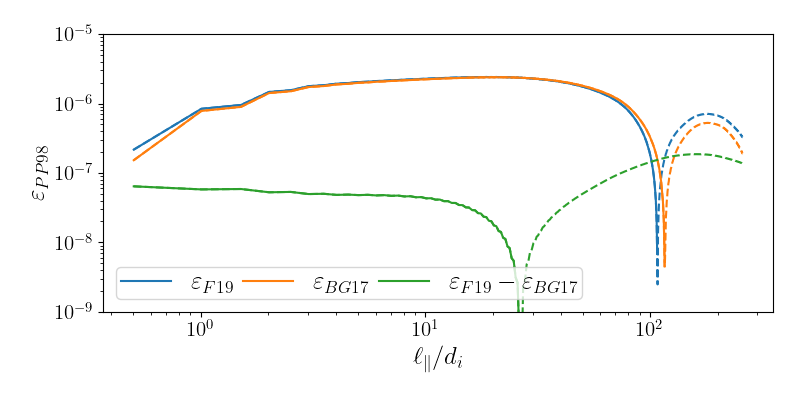

In [27]:
plt.figure('M3', figsize=(8,4))
plt.clf()
l1,_ = splot(axe_par[1:],np.nanmean(yF19*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{F19}$') 
l1,_ = splot(axe_par[1:],np.nanmean(yBG17*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{BG17}$') 
l1,_ = splot(axe_par[1:],np.nanmean(yF19*filt_45bsup-yBG17*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{F19} - \\varepsilon_{BG17}$') 
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-9,1e-5)
plt.ylabel('$\\varepsilon_{PP98}$')
plt.xlabel('$\ell_{\\parallel}/d_i$')
plt.legend(ncol=3,loc='lower left',columnspacing=0.4,labelspacing = 0.2,borderpad=0.2)
plt.tight_layout()
plt.show()

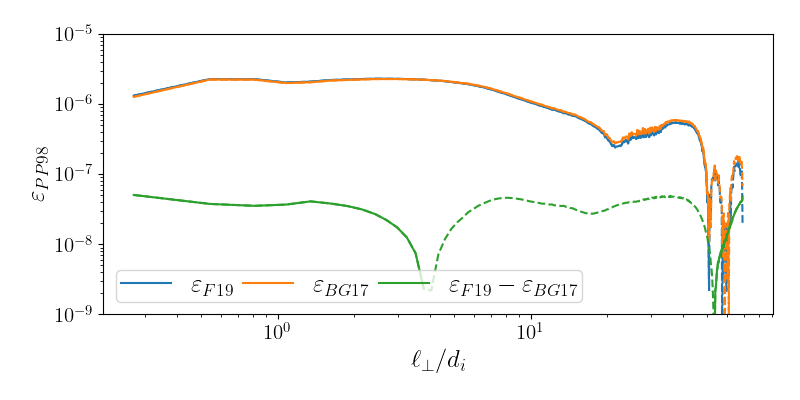

In [28]:
plt.figure('M4', figsize=(8,4))
plt.clf()
l1,_ = splot(axe_perp[1:],np.nanmean(yF19*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{F19}$') 
l1,_ = splot(axe_perp[1:],np.nanmean(yBG17*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{BG17}$') 
l1,_ = splot(axe_perp[1:],np.nanmean(yF19*filt_45binf-yBG17*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{F19} - \\varepsilon_{BG17}$') 
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-9,1e-5)
plt.ylabel('$\\varepsilon_{PP98}$')
plt.xlabel('$\ell_{\\perp}/d_i$')
plt.legend(ncol=3,loc='lower left',columnspacing=0.4,labelspacing = 0.2,borderpad=0.2)
plt.tight_layout()
plt.show()

In [19]:
from matplotlib import gridspec
X,Y = np.meshgrid(axe_perp,axe_par)
Z = yF19-yBG17

fig = plt.figure('M5', figsize=(10,10))
plt.clf()

spec = gridspec.GridSpec(ncols=3, nrows=2,
                         width_ratios=[1, 2,0.5], wspace=0,
                         hspace=0, height_ratios=[2, 1])


ax1 = plt.subplot(spec[1])
ax1.set_title('CGL2')
colormap = ax1.pcolor(X,Y,np.transpose(Z), norm=colors.SymLogNorm(linthresh = 1e-9, vmin = - np.max(np.abs(Z)), vmax=np.max(np.abs(Z))),
                   cmap='Spectral_r', shading='auto')

contours = ax1.contour(X,Y,np.transpose(Z),15,cmap='Spectral',vmin = - np.max(Z), vmax=np.max(Z))

ax1.plot(axe_perp[1:],axe_perp[1:]*np.tan(theta),'k-.',label='$\\theta = \\theta_i$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(axe_perp[1],axe_perp[-1])
ax1.set_ylim(axe_par[1],axe_par[-1])

ax0 = plt.subplot(spec[0],sharey=ax1)
subsplot(ax0,axe_par[1:],np.nanmean(yF19*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{F19}$',orientation = 'inverse') 
subsplot(ax0,axe_par[1:],np.nanmean(yBG17*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{BG17}$',orientation = 'inverse') 
subsplot(ax0,axe_par[1:],np.nanmean(yF19*filt_45bsup-yBG17*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{F19} - \\varepsilon_{BG17}$',orientation = 'inverse') 
ax0.plot([2,4],[4,5],'k-.',label='$\\theta = \\theta_i$')

ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlim(1e-9,9e-6)
ax0.set_ylabel('$\ell_{\\parallel}/d_i$')

ax4 = plt.subplot(spec[4],sharex=ax1)
subsplot(ax4,axe_perp[1:],np.nanmean(yF19*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{F19}$') 
subsplot(ax4,axe_perp[1:],np.nanmean(yBG17*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{BG17}$') 
subsplot(ax4,axe_perp[1:],np.nanmean(yF19*filt_45binf-yBG17*filt_45binf,axis=1)[1:],label = '$\\varepsilon_{F19} - \\varepsilon_{BG17}$') 
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_ylim(1e-9,9e-6)
ax4.set_xlabel('$\ell_{\\perp}/d_i$')

ax2 = plt.subplot(spec[2])
ax2.axis('off')

cbar = fig.colorbar(contours,ax = [ax2,],location='left',anchor=(0.7,0),pad=0.5, fraction=1,) #
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar2 = fig.colorbar(colormap,ax = [ax2,],location='right',label='$\\varepsilon_{F19} - \\varepsilon_{BG17}$',anchor=(-0.1,0), fraction=1) #

ax0.legend(bbox_to_anchor=(3.9, -0.1))
plt.show()

/tmp/ipykernel_51003/2797606112.py:6: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.clf()
/tmp/ipykernel_51003/2797606112.py:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.clf()
/tmp/ipykernel_51003/2797606112.py:27: RuntimeWarning: Mean of empty slice
  subsplot(ax0,axe_par[1:],np.nanmean(yF19*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{F19}$',orientation = 'inverse')
/tmp/ipykernel_51003/2797606112.py:28: RuntimeWarning: Mean of empty slice
  subsplot(ax0,axe_par[1:],np.nanmean(yBG17*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{BG17}$',orientation = 'inverse')
/tmp/ipykernel_51003/2797606112.py:29: RuntimeWarning: Mean of empty slice
  subsplot(ax0,axe_par[1:],np.nanmean(yF19*filt_45bsup-yBG17*filt_45bsup,axis=0)[1:],label = '$\\varepsilon_{F19} - \\varepsilon_{BG17}$',orientation = 'inverse')
